<a href="https://colab.research.google.com/github/ykato27/AutoEncorder/blob/main/AutoEncoder_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AutoEncoder-Pytorch

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pylab
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

In [2]:
class Mnisttox(Dataset):
    def __init__(self, datasets, labels: list):
        self.dataset = [
            datasets[i][0] for i in range(len(datasets)) if datasets[i][1] in labels
        ]
        self.labels = labels
        self.len_oneclass = int(len(self.dataset) / 10)

    def __len__(self):
        return int(len(self.dataset))

    def __getitem__(self, index):
        img = self.dataset[index]
        return img, []


class Autoencoder(nn.Module):
    def __init__(self, z_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        z = self.encoder(x)
        xhat = self.decoder(z)
        return xhat

In [3]:
z_dim = 64
batch_size = 16
num_epochs = 10
learning_rate = 3.0e-4
n = 6  # number of test sample
cuda = True
model = Autoencoder(z_dim)
mse_loss = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

if cuda:
    model.cuda()

img_transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]  # [0,1] => [-1,1]
)
train_dataset = MNIST("./data", download=True, train=True, transform=img_transform)
train_1 = Mnisttox(train_dataset, [1])
train_loader = DataLoader(train_1, batch_size=batch_size, shuffle=True)
losses = np.zeros(num_epochs)

for epoch in range(num_epochs):
    i = 0
    for img, _ in train_loader:

        x = img.view(img.size(0), -1)

        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)

        xhat = model(x)

        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = mse_loss(xhat, x)
        losses[epoch] = losses[epoch] * (i / (i + 1.0)) + loss * (1.0 / (i + 1.0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        i += 1

    plt.figure()
    pylab.xlim(0, num_epochs)
    plt.plot(range(0, num_epochs), losses, label="loss")
    plt.legend()
    plt.savefig("./loss.pdf")
    plt.close()

    print("epoch [{}/{}], loss: {:.4f}".format(epoch + 1, num_epochs, loss))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


epoch [1/10], loss: 0.0583
epoch [2/10], loss: 0.0373
epoch [3/10], loss: 0.0352
epoch [4/10], loss: 0.0442
epoch [5/10], loss: 0.0206
epoch [6/10], loss: 0.0148
epoch [7/10], loss: 0.0144
epoch [8/10], loss: 0.0188
epoch [9/10], loss: 0.0102
epoch [10/10], loss: 0.0231


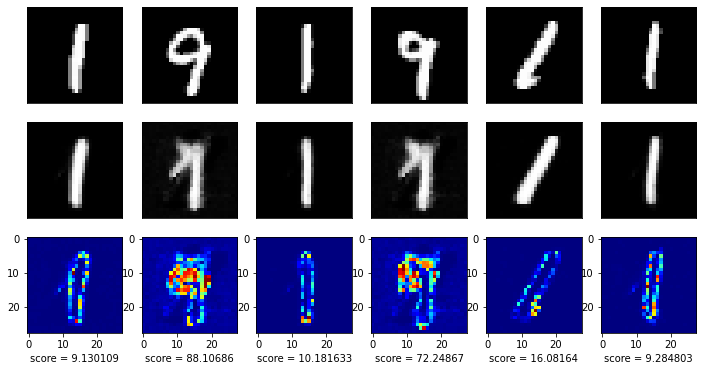

In [4]:
test_dataset = MNIST("./data", train=False, download=True, transform=img_transform)
test_1_9 = Mnisttox(test_dataset, [1, 9])
test_loader = DataLoader(test_1_9, batch_size=len(test_dataset), shuffle=True)

for img, _ in test_loader:
    x = img.view(img.size(0), -1)

    if cuda:
        x = Variable(x).cuda()
    else:
        x = Variable(x)

    xhat = model(x)
    x = x.cpu().detach().numpy()
    xhat = xhat.cpu().detach().numpy()
    x = x / 2 + 0.5
    xhat = xhat / 2 + 0.5

# サンプル画像表示
plt.figure(figsize=(12, 6))
for i in range(n):
    # テスト画像を表示
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 出力画像を表示
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(xhat[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 入出力の差分画像を計算
    diff_img = np.abs(x[i] - xhat[i])

    # 入出力の差分数値を計算
    diff = np.sum(diff_img)

    # 差分画像と差分数値の表示
    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(diff_img.reshape(28, 28), cmap="jet")
    # plt.gray()
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(True)
    ax.set_xlabel("score = " + str(diff))

plt.savefig("./result.png")
plt.show()
plt.close()